In [1]:
# Libraries and settings
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = "" # with this line we don't use the GPU to process
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFile
import time
from tqdm.notebook import tqdm

BASE_PATH = Path("..")
OUT_ROOT = BASE_PATH / Path("data/preprocessed_variants_2")
OUT_ROOT.mkdir(exist_ok=True)
SEED = 42
print("OUT_ROOT:", OUT_ROOT.resolve())


OUT_ROOT: /Users/juancamilosalazar/Documents/GitHub/clasificiacion_hortalizas/data/preprocessed_variants_2


In [2]:
# Grid: resolutions and jpeg qualities
resolutions = [(50,50), (64,64)]
jpeg_qualities = [50,70,90,95]

variants = []
for resolution in resolutions:
    for quality in jpeg_qualities:
        name = f"resolution_{resolution[0]}X{resolution[1]}_quality_{quality}"
        variants.append({'name':name, 'size':resolution, 'quality':quality})
print("Variants to create:", len(variants),"\n")
for variant  in variants:
    print(variant['name'])

Variants to create: 8 

resolution_50X50_quality_50
resolution_50X50_quality_70
resolution_50X50_quality_90
resolution_50X50_quality_95
resolution_64X64_quality_50
resolution_64X64_quality_70
resolution_64X64_quality_90
resolution_64X64_quality_95


In [3]:
# Utilities - functions
def save_jpeg_RGB(img_pil, out_path: Path, quality:int):
    out_path.parent.mkdir(parents=True, exist_ok=True)
    img = img_pil.convert('RGB')
    img.save(out_path,format='JPEG',quality=quality, optimize=True)
    return out_path.stat().st_size

In [4]:
# Load metadata
metadata_path = Path("../data/plantvillage_images_metadata.parquet")
df = pd.read_parquet(metadata_path)
df = df[df['plant_type'].isin(['Tomato'])]
df=df[df['image_type'].isin(['color'])]
print(df.head())
print(len(df))

                                              image_path image_type  \
59605  data/plantvillage dataset/color/Tomato___Targe...      color   
59606  data/plantvillage dataset/color/Tomato___Targe...      color   
59607  data/plantvillage dataset/color/Tomato___Targe...      color   
59608  data/plantvillage dataset/color/Tomato___Targe...      color   
59609  data/plantvillage dataset/color/Tomato___Targe...      color   

      plant_type    condition  file_size_bytes  width  height  file_size_kb  \
59605     Tomato  Target_Spot            21451    256     256     20.948242   
59606     Tomato  Target_Spot            18866    256     256     18.423828   
59607     Tomato  Target_Spot            21725    256     256     21.215820   
59608     Tomato  Target_Spot            19691    256     256     19.229492   
59609     Tomato  Target_Spot            20547    256     256     20.065430   

       file_size_mb  
59605      0.020457  
59606      0.017992  
59607      0.020719  
59608     

In [5]:
path_per_class = df.groupby('condition')['image_path'].apply(list).to_dict()

In [6]:
df.condition.nunique()

10

In [7]:
variants


[{'name': 'resolution_50X50_quality_50', 'size': (50, 50), 'quality': 50},
 {'name': 'resolution_50X50_quality_70', 'size': (50, 50), 'quality': 70},
 {'name': 'resolution_50X50_quality_90', 'size': (50, 50), 'quality': 90},
 {'name': 'resolution_50X50_quality_95', 'size': (50, 50), 'quality': 95},
 {'name': 'resolution_64X64_quality_50', 'size': (64, 64), 'quality': 50},
 {'name': 'resolution_64X64_quality_70', 'size': (64, 64), 'quality': 70},
 {'name': 'resolution_64X64_quality_90', 'size': (64, 64), 'quality': 90},
 {'name': 'resolution_64X64_quality_95', 'size': (64, 64), 'quality': 95}]

In [8]:
path_per_class[df.condition.unique()[0]][0]

'data/plantvillage dataset/color/Tomato___Target_Spot/c6fc37bf-8462-49c9-ac5c-a5f078e34ea4___Com.G_TgS_FL 7958.JPG'

In [9]:
# Preprocesses
results = []
start_all = time.perf_counter()

for variant in variants:
    start_time = time.perf_counter()
    print(f"\nVariant Preprocessing: {variant['name']}")
    out_base= OUT_ROOT/variant['name']
    total_images = sum(len(value) for value in path_per_class.values())
    pbar = tqdm(total=total_images)
    errors = 0
    for clss, paths in path_per_class.items():
        for path in paths:
            try:
                image = Image.open(BASE_PATH/path).convert('RGB')
            except Exception as e:
                errors += 1
                print(f"error: {e}")
                pbar.update(1)
                continue
            # resize
            image_resized = image.resize(variant['size'], resample=Image.Resampling.LANCZOS)
            # Remove "data/" prefix from path if present
            out_path = out_base/clss/Path(path).name
            try:
                size_bytes = save_jpeg_RGB(image_resized, out_path, variant['quality'])
            except Exception as e:
                errors+=1
                print(f"error: {e}")
            pbar.update(1)
    pbar.close()
    end_time = time.perf_counter()
    time_per_variant = end_time-start_time
    print(f"Time needed: {time_per_variant:.4f} seconds")
    results.append({
        'variant':variant['name'],
        'resolution':variant['size'][0]+variant['size'][1],
        'quality':variant['quality'],
        'images':total_images,
        'errors':errors,
        'time_seconds':round(time_per_variant,4)
    })
end_all = time.perf_counter()
print(f"\nPreprocess completed in {end_all - start_all:.4f} seconds")
# Save results in csv
df = pd.DataFrame(results)
df.to_csv(OUT_ROOT/"variant_result_status.csv",index=False)
df


Variant Preprocessing: resolution_50X50_quality_50


  0%|          | 0/18160 [00:00<?, ?it/s]

Time needed: 26.3486 seconds

Variant Preprocessing: resolution_50X50_quality_70


  0%|          | 0/18160 [00:00<?, ?it/s]

Time needed: 22.4825 seconds

Variant Preprocessing: resolution_50X50_quality_90


  0%|          | 0/18160 [00:00<?, ?it/s]

Time needed: 23.0238 seconds

Variant Preprocessing: resolution_50X50_quality_95


  0%|          | 0/18160 [00:00<?, ?it/s]

Time needed: 23.2792 seconds

Variant Preprocessing: resolution_64X64_quality_50


  0%|          | 0/18160 [00:00<?, ?it/s]

Time needed: 23.3392 seconds

Variant Preprocessing: resolution_64X64_quality_70


  0%|          | 0/18160 [00:00<?, ?it/s]

Time needed: 23.3063 seconds

Variant Preprocessing: resolution_64X64_quality_90


  0%|          | 0/18160 [00:00<?, ?it/s]

Time needed: 23.6925 seconds

Variant Preprocessing: resolution_64X64_quality_95


  0%|          | 0/18160 [00:00<?, ?it/s]

Time needed: 23.9068 seconds

Preprocess completed in 189.3794 seconds


,variant,resolution,quality,images,errors,time_seconds
0,resolution_50X50_quality_50,100,50,18160,0,26.3486
1,resolution_50X50_quality_70,100,70,18160,0,22.4825
2,resolution_50X50_quality_90,100,90,18160,0,23.0238
3,resolution_50X50_quality_95,100,95,18160,0,23.2792
4,resolution_64X64_quality_50,128,50,18160,0,23.3392
5,resolution_64X64_quality_70,128,70,18160,0,23.3063
6,resolution_64X64_quality_90,128,90,18160,0,23.6925
7,resolution_64X64_quality_95,128,95,18160,0,23.9068


../data/preprocessed_variants_2


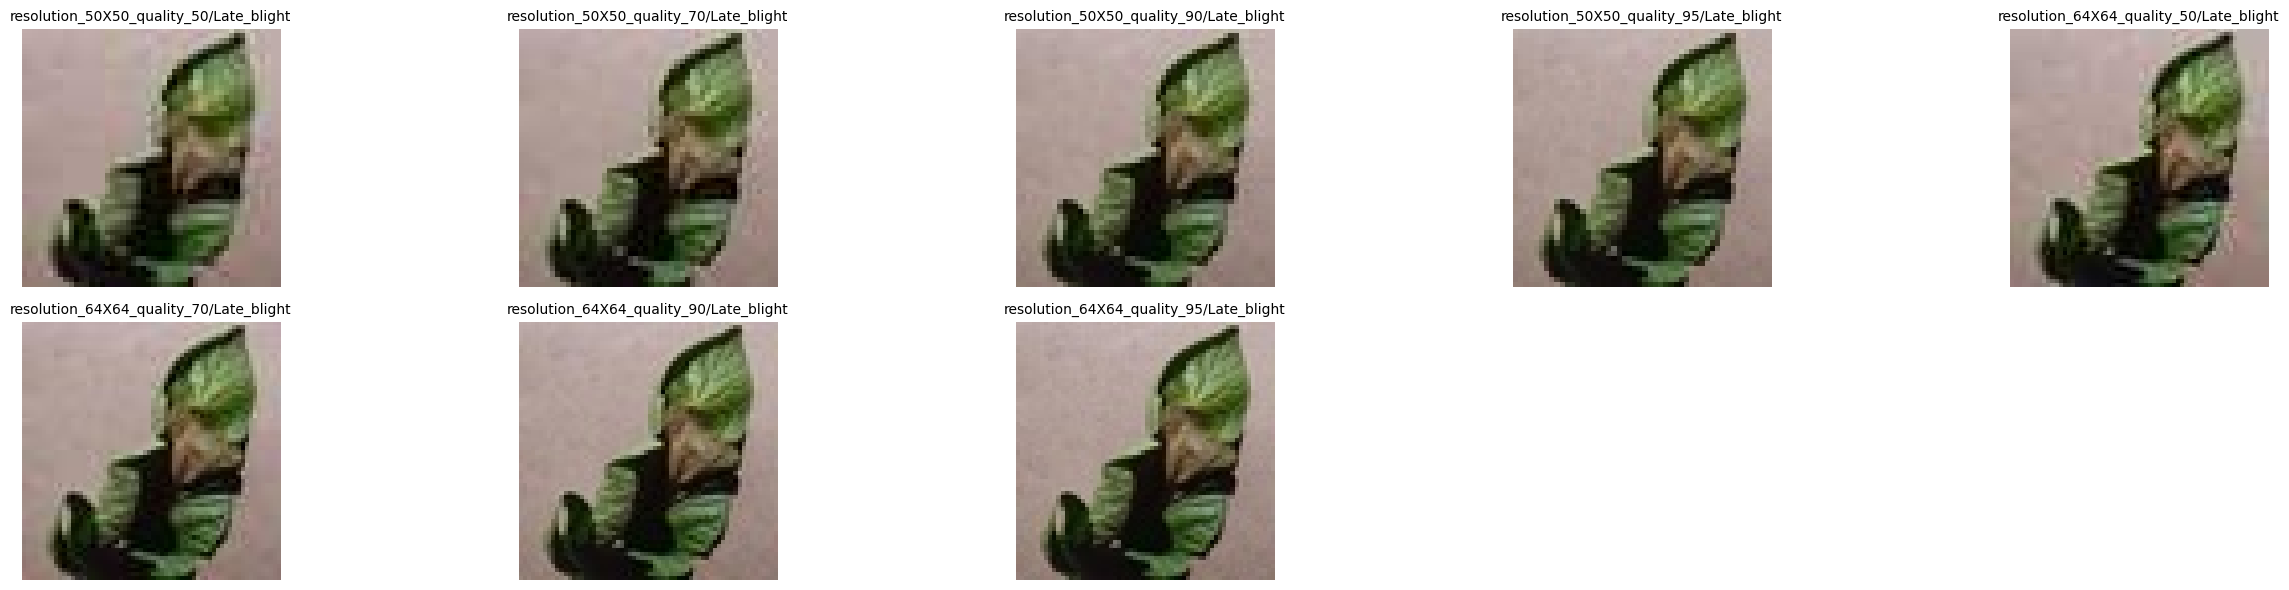

In [15]:
# Screen example per variant
images_example = []
titles = []
print(OUT_ROOT)
for folder2 in sorted(OUT_ROOT.iterdir()):
    if folder2.is_dir():
        folders3 = sorted([folder3 for folder3 in folder2.iterdir() if folder3.is_dir()])
        if not folders3:
            continue
        folder3 = folders3[2]
        image_file = sorted(folder3.glob("*"))
        img = Image.open(image_file[0]).convert("RGB")
        images_example.append(img)
        titles.append(f"{folder2.name}/{folder3.name}")
    
num_images = len(images_example)
cols = 5
rows = (num_images+cols-1)//cols
plt.figure(figsize=(cols*5,rows*3))
for i, (img, title) in enumerate(zip(images_example, titles)):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.title(title, fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()